**Download data from NYC Open Data API, explore, and clean it**

In [ ]:
%%capture
!pip install sodapy #the opendata portal api

In [ ]:
import requests
import pandas as pd

app_token = "zh9tilVBQr3vaMs4egSsdQDyD"
base_url = "https://data.cityofnewyork.us/resource/erm2-nwe9.json?"

agency = 'HPD'

excluded_complaint_types = ['UNSANITARY CONDITION', 'HEAT/HOT WATER']
excluded_complaint_type_str = ', '.join([f"'{ctype}'" for ctype in excluded_complaint_types])

date = "2023-01-01T12%3A00%3A00.000"

query = f"%24where=created_date%3E%27{date}%27%20AND%20agency%3D%27{agency}%27%20AND%20complaint_type%20NOT%20IN%20%28{excluded_complaint_type_str}%29"

limit = 1000

all_data = []
offset = 0
page = 1
while True:
    url = f"{base_url}{query}&%24%24app_token={app_token}&%24limit={limit}&%24offset={offset}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        if not data:  # If there's no data, it means we reached the end
            break
            
        # print(f"Grabbed {page} pages of records")
        # if page > 100:
          # break
        page += 1
        
        all_data.extend(data)
        offset += limit  # Increment the offset to get the next batch of records
    else:
        print(f"Error: {response.status_code}")
        break

data_df = pd.DataFrame(all_data)
print(data_df.head())
print("Number of rows:", data_df.shape[0])
print("Earliest created date:", data_df['created_date'].min())

  unique_key             created_date agency  \
0   57511188  2023-05-05T23:09:45.000    HPD   
1   57513945  2023-05-05T23:02:38.000    HPD   
2   57512943  2023-05-05T23:02:38.000    HPD   
3   57517994  2023-05-05T23:02:38.000    HPD   
4   57510023  2023-05-05T23:02:38.000    HPD   

                                         agency_name complaint_type  \
0  Department of Housing Preservation and Develop...        GENERAL   
1  Department of Housing Preservation and Develop...  PAINT/PLASTER   
2  Department of Housing Preservation and Develop...    DOOR/WINDOW   
3  Department of Housing Preservation and Develop...      APPLIANCE   
4  Department of Housing Preservation and Develop...    DOOR/WINDOW   

           descriptor         location_type incident_zip  \
0  VENTILATION SYSTEM  RESIDENTIAL BUILDING        10459   
1                WALL  RESIDENTIAL BUILDING        10302   
2        WINDOW FRAME  RESIDENTIAL BUILDING        10302   
3  ELECTRIC/GAS RANGE  RESIDENTIAL BUILDING 

In [ ]:
column_names = list(data_df.columns)
print(column_names)

['unique_key', 'created_date', 'agency', 'agency_name', 'complaint_type', 'descriptor', 'location_type', 'incident_zip', 'incident_address', 'street_name', 'address_type', 'city', 'status', 'resolution_description', 'resolution_action_updated_date', 'community_board', 'bbl', 'borough', 'x_coordinate_state_plane', 'y_coordinate_state_plane', 'open_data_channel_type', 'park_facility_name', 'park_borough', 'latitude', 'longitude', 'location', 'closed_date']


In [ ]:
data_df['created_date'] = pd.to_datetime(data_df['created_date']).dt.strftime('%m/%d/%Y')
data_df['closed_date'] = pd.to_datetime(data_df['closed_date']).dt.strftime('%m/%d/%Y')

In [ ]:
# Get unique values and their counts in the 'resolution_description' column
resolution_description_counts = data_df['status'].value_counts()

# Print the unique values and their counts
print(resolution_description_counts)

Closed    81682
Open      23613
Name: status, dtype: int64


In [ ]:
# Get unique values and their counts in the 'resolution_description' column
resolution_description_counts = data_df['resolution_description'].value_counts()

# Print the unique values and their counts
print(resolution_description_counts)

The Department of Housing Preservation and Development inspected the following conditions. No violations were issued. The complaint has been closed.                                                                                                                                                                                               44914
The following complaint conditions are still open. HPD may attempt to contact you to verify the correction of the condition or may conduct an inspection.                                                                                                                                                                                          23195
The Department of Housing Preservation and Development inspected the following conditions. Violations were issued. Information about specific violations is available at www.nyc.gov/hpd                                                                                                                              

In [ ]:
import numpy as np
pd.set_option("display.max_columns", None)
# Get the top 5 resolution descriptions
top_5_res_desc = data_df['resolution_description'].value_counts().nlargest(5).index

# Filter the dataset
filtered_data_df = data_df[data_df['resolution_description'].isin(top_5_res_desc)].copy()

# Create conditions
conditions = [
    (filtered_data_df['resolution_description'] == top_5_res_desc[0]),
    (filtered_data_df['resolution_description'] == top_5_res_desc[1]),
    (filtered_data_df['resolution_description'] == top_5_res_desc[2]),
    (filtered_data_df['resolution_description'] == top_5_res_desc[4]),
]

# Create corresponding status values for each condition
status_values = ['CLOSED', 'IN PROGRESS', 'CLOSED', 'IN PROGRESS']

# Apply the conditions to the DataFrame
filtered_data_df['status'] = np.select(conditions, status_values, default=filtered_data_df['status'])
filtered_data_df['status'] = filtered_data_df['status'].str.upper()

# Display the updated DataFrame
print(filtered_data_df.head())
print(filtered_data_df.shape)

  unique_key created_date agency  \
0   57511188   05/05/2023    HPD   
1   57513945   05/05/2023    HPD   
2   57512943   05/05/2023    HPD   
3   57517994   05/05/2023    HPD   
4   57510023   05/05/2023    HPD   

                                         agency_name complaint_type  \
0  Department of Housing Preservation and Develop...        GENERAL   
1  Department of Housing Preservation and Develop...  PAINT/PLASTER   
2  Department of Housing Preservation and Develop...    DOOR/WINDOW   
3  Department of Housing Preservation and Develop...      APPLIANCE   
4  Department of Housing Preservation and Develop...    DOOR/WINDOW   

           descriptor         location_type incident_zip  \
0  VENTILATION SYSTEM  RESIDENTIAL BUILDING        10459   
1                WALL  RESIDENTIAL BUILDING        10302   
2        WINDOW FRAME  RESIDENTIAL BUILDING        10302   
3  ELECTRIC/GAS RANGE  RESIDENTIAL BUILDING        10302   
4                DOOR  RESIDENTIAL BUILDING        10302

In [ ]:
status_counts = filtered_data_df['status'].value_counts()
print(status_counts)

CLOSED         72231
IN PROGRESS    27252
Name: status, dtype: int64


In [ ]:
pd.set_option('display.max_rows', None)

complaint_type_counts = data_df['complaint_type'].value_counts()
print(complaint_type_counts)

PLUMBING            21142
PAINT/PLASTER       18696
DOOR/WINDOW         14577
WATER LEAK          13025
GENERAL              9333
ELECTRIC             9031
FLOORING/STAIRS      8335
APPLIANCE            6428
SAFETY               3940
ELEVATOR              523
OUTSIDE BUILDING      265
Name: complaint_type, dtype: int64


In [ ]:
# compare filtered to original data

complaint_type_counts = filtered_data_df['complaint_type'].value_counts()
print(complaint_type_counts)

PLUMBING            19677
PAINT/PLASTER       17323
DOOR/WINDOW         14026
WATER LEAK          12376
ELECTRIC             8612
GENERAL              8428
FLOORING/STAIRS      8140
APPLIANCE            6277
SAFETY               3855
ELEVATOR              507
OUTSIDE BUILDING      262
Name: complaint_type, dtype: int64


In [ ]:
specific_complaint_type = 'PLUMBING'

complaint_type_descriptor_counts = data_df.groupby(['complaint_type', 'descriptor']).size().reset_index(name='count')
filtered_counts = complaint_type_descriptor_counts[complaint_type_descriptor_counts['complaint_type'] == specific_complaint_type]
sorted_counts = filtered_counts.sort_values(by='count', ascending=False)
print(sorted_counts)

   complaint_type        descriptor  count
42       PLUMBING      WATER SUPPLY   5805
35       PLUMBING        BASIN/SINK   5434
36       PLUMBING    BATHTUB/SHOWER   4161
41       PLUMBING            TOILET   3245
38       PLUMBING          RADIATOR   1749
40       PLUMBING  STEAM PIPE/RISER    688
39       PLUMBING             SEWER     35
37       PLUMBING            BOILER     25


In [ ]:
given_complaint_type = "HEAT/HOT WATER"  # Replace this with the desired complaint type

filtered_records = data_df.query(f"complaint_type == '{given_complaint_type}'")
display(filtered_records.head(20))


,unique_key,created_date,agency,agency_name,complaint_type,descriptor,location_type,incident_zip,incident_address,street_name,...,borough,x_coordinate_state_plane,y_coordinate_state_plane,open_data_channel_type,park_facility_name,park_borough,latitude,longitude,location,closed_date
0,57497493,2023-05-03,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10032,657 WEST 161 STREET,WEST 161 STREET,...,MANHATTAN,999403,244399,ONLINE,Unspecified,MANHATTAN,40.8374810891736,-73.94523849972839,"{'latitude': '40.8374810891736', 'longitude': ...",NaT
1,57491299,2023-05-03,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10467,3051 DECATUR AVENUE,DECATUR AVENUE,...,BRONX,1017650,256592,MOBILE,Unspecified,BRONX,40.8708970496833,-73.87923488967775,"{'latitude': '40.8708970496833', 'longitude': ...",NaT
2,57491362,2023-05-03,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,10035,243 EAST 120 STREET,EAST 120 STREET,...,MANHATTAN,1001657,230780,ONLINE,Unspecified,MANHATTAN,40.800096621444304,-73.93712808629013,"{'latitude': '40.800096621444304', 'longitude'...",NaT
4,57498596,2023-05-03,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,11106,31-35 CRESCENT STREET,CRESCENT STREET,...,QUEENS,1004421,217880,MOBILE,Unspecified,QUEENS,40.76468368198577,-73.92718359841146,"{'latitude': '40.76468368198577', 'longitude':...",NaT
5,57497612,2023-05-03,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,11215,691 UNION STREET,UNION STREET,...,BROOKLYN,989258,185923,ONLINE,Unspecified,BROOKLYN,40.67699102790878,-73.98194511945508,"{'latitude': '40.67699102790878', 'longitude':...",NaT
7,57493387,2023-05-03,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10467,66 WEST GUN HILL ROAD,WEST GUN HILL ROAD,...,BRONX,1016249,261075,MOBILE,Unspecified,BRONX,40.88320667838292,-73.88427909662423,"{'latitude': '40.88320667838292', 'longitude':...",NaT
8,57496971,2023-05-03,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10462,1314 VIRGINIA AVENUE,VIRGINIA AVENUE,...,BRONX,1022502,243166,ONLINE,Unspecified,BRONX,40.83402702113464,-73.86176803987782,"{'latitude': '40.83402702113464', 'longitude':...",NaT
9,57499523,2023-05-03,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,ENTIRE BUILDING,RESIDENTIAL BUILDING,10462,2109 GLEASON AVENUE,GLEASON AVENUE,...,BRONX,1024841,242292,MOBILE,Unspecified,BRONX,40.83161770547177,-73.85332085627955,"{'latitude': '40.83161770547177', 'longitude':...",NaT
10,57496162,2023-05-03,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,10457,1770 GRAND CONCOURSE,GRAND CONCOURSE,...,BRONX,1009178,247528,ONLINE,Unspecified,BRONX,40.84604709368425,-73.90990096893466,"{'latitude': '40.84604709368425', 'longitude':...",NaT
11,57494796,2023-05-03,HPD,Department of Housing Preservation and Develop...,HEAT/HOT WATER,APARTMENT ONLY,RESIDENTIAL BUILDING,11225,580 EMPIRE BOULEVARD,EMPIRE BOULEVARD,...,BROOKLYN,1000033,181220,ONLINE,Unspecified,BROOKLYN,40.66406969404813,-73.9431100244629,"{'latitude': '40.66406969404813', 'longitude':...",NaT


In [ ]:
# List of complaint types
complaint_types = ['PAINT/PLASTER', 'PLUMBING', 'WATER LEAK', 'DOOR/WINDOW', 'ELECTRIC', 'FLOORING/STAIRS']

# Initialize an empty list to store the sampled data
sampled_data_list = []

# Iterate over complaint types and sample 2,000 records from each group
for ctype in complaint_types:
    sampled_data = filtered_data_df[filtered_data_df['complaint_type'] == ctype].sample(n=2000, random_state=42)
    sampled_data_list.append(sampled_data)

# Concatenate the sampled data using pd.concat()
balanced_df = pd.concat(sampled_data_list)

# Reset index of the balanced DataFrame
balanced_df.reset_index(drop=True, inplace=True)

balanced_type_counts = balanced_df['complaint_type'].value_counts()
print(balanced_type_counts)

PAINT/PLASTER      2000
PLUMBING           2000
WATER LEAK         2000
DOOR/WINDOW        2000
ELECTRIC           2000
FLOORING/STAIRS    2000
Name: complaint_type, dtype: int64


In [ ]:
# TODO Extract vocab and create BOW vector for set of keywords
# TODO Format DF to have the following schema
'''
reports_table.update_item(
        Key={"ID": report_info["reportID"]}, # use UUID
        UpdateExpression="SET userID = :userID, title = :title, #location = :location, description = :description, #date = :date, closed_date = :closed_date, imageKeys = :imageKeys, #status = :status",
        ExpressionAttributeNames={
            "#location": "location",
            "#date": "date",
            "#status": "status",
        },
        ExpressionAttributeValues={
            ":userID": report_info["userID"], # create a randomized uni
            ":title": report_info["title"], # generate a title based on the complaint_type
            ":location": report_info["location"], # random CU location
            ":description": report_info["description"], # based on complaint descriptor
            ":date": report_info["date"], # based on created_date
            ":closed_date": #closed_date
            ":imageKeys": None,
            ":status": INITIAL_STATUS,
        },
'''
# TODO Upload to dynamo

In [ ]:
import random
import string
from uuid import uuid1, uuid4
import pandas as pd

def generate_random_userID():
    letters = ''.join(random.choice(string.ascii_lowercase) for _ in range(2))
    numbers = ''.join(random.choice(string.digits) for _ in range(4))
    return letters + numbers

# Apply user and report IDs to each record
balanced_df['userID'] = balanced_df.apply(lambda x: generate_random_userID(), axis=1)
balanced_df['reportID'] = balanced_df.apply(lambda x: f"RPT-{uuid1()}", axis=1)

# Print the first 5 rows
print(balanced_df.head())

  unique_key created_date agency  \
0   57092811   03/20/2023    HPD   
1   57059256   03/16/2023    HPD   
2   57072675   03/17/2023    HPD   
3   56992180   03/08/2023    HPD   
4   56871759   02/22/2023    HPD   

                                         agency_name complaint_type  \
0  Department of Housing Preservation and Develop...  PAINT/PLASTER   
1  Department of Housing Preservation and Develop...  PAINT/PLASTER   
2  Department of Housing Preservation and Develop...  PAINT/PLASTER   
3  Department of Housing Preservation and Develop...  PAINT/PLASTER   
4  Department of Housing Preservation and Develop...  PAINT/PLASTER   

  descriptor         location_type incident_zip        incident_address  \
0       WALL  RESIDENTIAL BUILDING        10458        2342 RYER AVENUE   
1       WALL  RESIDENTIAL BUILDING        11203        646 RUTLAND ROAD   
2       WALL  RESIDENTIAL BUILDING        10458   2908 VALENTINE AVENUE   
3       WALL  RESIDENTIAL BUILDING        10463  2600 NE

In [ ]:
# Apply cleaning and transformations to fit our schema
import random

locations = [
    ("ALT", "Altschul Hall"), 
    ("AVH",	"Avery Hall"), 
    ("BAR", "Barnard Hall"), 
    ("BUT", "Butler Library"), 
    ("BWY", "Broadway Residence Hall"),
    ("DIA", "Diana Center"),
    ("DOD",	"Dodge Building"),
    ("FLS",	"Fairchild Life Sciences Building"),
    ("HAM",	"Hamilton Hall"),
    ("IAB",	"International Affairs Building"),
    ("JRN",	"Journalism Building"),
    ("KNT",	"Kent Hall"),
    ("KNX",	"Knox Hall"),
    ("LEH",	"Lehman Hall"),
    ("LER",	"Alfred Lerner Hall"),
    ("LEW",	"Lewisohn Hall"),
    ("MAT",	"Mathematics Building"),
    ("MCY",	"Macy Hall"),
    ("MIL",	"Milbank Hall, Barnard"),
    ("MLC", "Milstein Center, Barnard"),
    ("MUD",	"Seeley W. Mudd Building"),
    ("NWC",	"Northwest Corner"),
    ("PHI",	"Philosophy Hall"),
    ("PRN",	"Prentis Hall"),
    ("PUP",	"Pupin Laboratories"),
    ("SCEP", "Schapiro Center"),
    ("SCH",	"Schermerhorn Hall"),
    ("SCHP", "Schapiro Residence Hall"),
    ("URI",	"Uris Hall"),
    ("UTS",	"Union Theological Seminary")
]

new_keywords = [
    "broken",
    "cracked",
    "wet",
    "torn",
    "damaged",
    "defective",
    "dirty",
    "collapsed",
    "stained",
    "rusty",
    "loose",
    "warped",
    "leaking",
    "clogged",
    "malfunctioning",
    "chipped",
    "peeling",
    "dented",
    "rotted",
    "scratched",
    "moldy",
    "discolored",
    "flooded",
    "frayed",
    "faulty",
    "sagging",
    "obstructed",
    "scuffed",
    "corroded",
    "bent",
    "uneven",
    "burned",
    "hazardous",
    "jammed",
    "detached",
    "unstable",
    "splintered",
]

def generate_random_location_code():
    return random.choice(locations)

def generate_random_keywords(keywords_str, new_keywords, num_random_words=2, remove_prob=.4):
    keywords = set(keywords_str.replace(",", "").replace("/", " ").split(" "))
    # Remove certain words that don't provide meaning or are too common
    keywords.discard("to")
    keywords.discard("no")
    if "residential" in keywords and random.random() < remove_prob:
        keywords.discard("residential")
    if "building" in keywords and random.random() < remove_prob:
        keywords.discard("building")

    random_keywords = set(random.sample(new_keywords, num_random_words))
    return keywords.union(random_keywords)

balanced_df['cu_code'], balanced_df['cu_location'] = zip(*balanced_df.apply(lambda x: generate_random_location_code(), axis=1))
balanced_df['title'] = balanced_df.apply(lambda x: f"{x['complaint_type']} in {x['cu_location']}", axis=1)
balanced_df['description'] = balanced_df.apply(lambda x: f"{x['complaint_type']} {x['descriptor']} in {x['location_type']}", axis=1)
balanced_df['keywords_str'] = balanced_df.apply(lambda x: f"{x['complaint_type']}, {x['descriptor']}, {x['location_type']}", axis=1)
balanced_df['keywords_str'] = balanced_df['keywords_str'].str.lower() # keywords_str is an intermediate value that will need to reassigned to keywords as a set
balanced_df['keywords'] = balanced_df['keywords_str'].apply(lambda x: generate_random_keywords(x, new_keywords))

# Print the first 5 rows
print(balanced_df.head())

  unique_key created_date agency  \
0   57092811   03/20/2023    HPD   
1   57059256   03/16/2023    HPD   
2   57072675   03/17/2023    HPD   
3   56992180   03/08/2023    HPD   
4   56871759   02/22/2023    HPD   

                                         agency_name complaint_type  \
0  Department of Housing Preservation and Develop...  PAINT/PLASTER   
1  Department of Housing Preservation and Develop...  PAINT/PLASTER   
2  Department of Housing Preservation and Develop...  PAINT/PLASTER   
3  Department of Housing Preservation and Develop...  PAINT/PLASTER   
4  Department of Housing Preservation and Develop...  PAINT/PLASTER   

  descriptor         location_type incident_zip        incident_address  \
0       WALL  RESIDENTIAL BUILDING        10458        2342 RYER AVENUE   
1       WALL  RESIDENTIAL BUILDING        11203        646 RUTLAND ROAD   
2       WALL  RESIDENTIAL BUILDING        10458   2908 VALENTINE AVENUE   
3       WALL  RESIDENTIAL BUILDING        10463  2600 NE

In [ ]:
import pandas as pd
import re

# Assuming the 'keywords' column contains strings of words separated by ', ', '/', or ' '
unique_words = set()

for keyword_set in balanced_df['keywords']:
    unique_words.update(keyword_set)

# Discard unwanted words
unique_words.discard("to")
unique_words.discard("no")

# Sort the unique words for better readability
unique_words = sorted(unique_words)

# Print the unique words
num = 1
print("Unique words in the 'keywords' column:")
for word in unique_words:
    print(word)
    num += 1
print(f"there are {num} keywords")

Unique words in the 'keywords' column:
basin
bathtub
bent
boiler
broken
building
burned
cabinet
ceiling
chipped
clogged
collapsed
corroded
cracked
damaged
damp
defective
dented
detached
dirty
discolored
door
dumbwaiter
electric
faulty
flooded
floor
flooring
flow
frame
frayed
hazardous
heavy
jammed
leak
leaking
lighting
loose
malfunctioning
moldy
obstructed
outage
outlet
paint
pane
peeling
pipe
plaster
plumbing
power
radiator
residential
riser
rotted
rusty
sagging
scratched
scuffed
sewer
shower
sink
slow
splintered
spot
stained
stairs
steam
supply
switch
toilet
torn
uneven
unstable
wall
warped
water
wet
window
wiring
there are 80 keywords


**Vectorize, build a vocabulary.txt file, and use PCA to create dense vectors IGNORE**

In [ ]:
# Combine keywords and CU building code into a single column that will act as vector
# We're not doing this anymore so ignore

# Assuming you have the balanced_df DataFrame

# Define a custom tokenizer function that splits on commas
def custom_tokenizer(s):
    return s.split(', ')

# Combine 'keywords' and 'cu_code' in a new column
balanced_df['combined_keywords_cu_code'] = balanced_df.apply(lambda x: f"{x['keywords']}, {x['cu_code']}", axis=1)

print(balanced_df.head())

  unique_key created_date agency  \
0   57027240   03/12/2023    HPD   
1   56866509   02/22/2023    HPD   
2   57073964   03/17/2023    HPD   
3   56730032   02/06/2023    HPD   
4   56679647   02/01/2023    HPD   

                                         agency_name complaint_type  \
0  Department of Housing Preservation and Develop...  PAINT/PLASTER   
1  Department of Housing Preservation and Develop...  PAINT/PLASTER   
2  Department of Housing Preservation and Develop...  PAINT/PLASTER   
3  Department of Housing Preservation and Develop...  PAINT/PLASTER   
4  Department of Housing Preservation and Develop...  PAINT/PLASTER   

  descriptor         location_type incident_zip       incident_address  \
0    CEILING  RESIDENTIAL BUILDING        10451   341 EAST  146 STREET   
1    CEILING  RESIDENTIAL BUILDING        10026  40 ST NICHOLAS AVENUE   
2       WALL  RESIDENTIAL BUILDING        11210    36 KENILWORTH PLACE   
3    CEILING  RESIDENTIAL BUILDING        11101        38-39

In [ ]:
# Build the vocabulary and write it to a file
# Create an empty set to store unique words
vocabulary = set()

# Add words from the 'keywords' column
for keywords in balanced_df['keywords']:
    words = keywords.split(', ')
    for word in words:
        vocabulary.add(word.lower())

# Add words from the 'cu_code' column
for cu_code in balanced_df['cu_code']:
    vocabulary.add(cu_code.lower())

# Write the vocabulary to a file
with open('vocabulary.txt', 'w') as vocab_file:
    sorted_vocabulary = sorted(vocabulary)
    for word in sorted_vocabulary[:-1]:
        vocab_file.write(f"{word}\n")
    vocab_file.write(sorted_vocabulary[-1])  # Write the last word without a newline

In [ ]:
import pandas as pd
import numpy as np

def load_vocabulary(filepath):
    with open(filepath, 'r') as f:
        vocab = f.read().splitlines()
    return {word: idx for idx, word in enumerate(vocab)}


def bag_of_words(words, vocabulary):
    vector = [0] * len(vocabulary)
    for word in words:
        if word in vocabulary:
            vector[vocabulary[word]] += 1
    return vector

vocab_filepath = 'vocabulary.txt'
vocabulary = load_vocabulary(vocab_filepath)

bag_of_words_list = []

for index, row in balanced_df.iterrows():
    document = row['combined_keywords_cu_code']
    vector = bag_of_words(document, vocabulary)
    bag_of_words_list.append(vector)

bag_of_words_matrix = np.array(bag_of_words_list)

# Save the matrix to a file
np.save('matrix.npy', bag_of_words_matrix)


In [ ]:
import numpy as np

def mean_center(matrix):
    return matrix - np.mean(matrix, axis=0)

def covariance_matrix(matrix):
    return np.dot(matrix.T, matrix) / (matrix.shape[0] - 1)

def pca(matrix, num_components):
    # Mean center the data
    mean_centered_matrix = mean_center(matrix)

    # Calculate the covariance matrix
    cov_matrix = covariance_matrix(mean_centered_matrix)

    # Calculate the eigenvalues and eigenvectors
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)

    # Sort the eigenvectors in descending order of their corresponding eigenvalues
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]

    # Select the first 'num_components' eigenvectors
    principal_components = sorted_eigenvectors[:, :num_components]

    # Project the data onto the reduced-dimension space
    reduced_data = np.dot(mean_centered_matrix, principal_components)

    return reduced_data


In [ ]:
import json

def process_words(words):
    # Load the matrix from the file
    bag_of_words_matrix = np.load('matrix.npy')

    # Load the vocabulary from the local file
    vocab_filepath = 'vocabulary.txt'
    vocabulary = load_vocabulary(vocab_filepath)

    # Vectorize the new input document
    new_vector = bag_of_words(words, vocabulary)

    # Append the new vector to the existing bag_of_words_matrix
    extended_matrix = np.vstack((bag_of_words_matrix, new_vector))

    # Perform PCA and reduce the dimensionality to a desired value (e.g., 2)
    reduced_data = pca(extended_matrix, 5)

    # The last row of the reduced_data matrix corresponds to the new input document
    new_document_reduced = reduced_data[-1]

    return {
        'statusCode': 200,
        'input_vector': json.dumps(new_vector),
        'reduced_vector': json.dumps(new_document_reduced.tolist())
    }

# Example usage
words = ['paint/plaster', 'ceiling', 'residential building', 'FLS']
result = process_words(words)
print("Input Vector:", json.loads(result['input_vector']))
print("Reduced Vector (PCA):", json.loads(result['reduced_vector']))


Input Vector: [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Reduced Vector (PCA): [1.7319064820287082, 1.2896679167035034e-16, 4.78796914068403e-17, 0.0, 0.0]


In [ ]:
# This combines the three code blocks above
import pandas as pd
import numpy as np

# Define the load_vocabulary, bag_of_words, mean_center, covariance_matrix, pca, and process_words functions

def load_vocabulary(filepath):
    with open(filepath, 'r') as f:
        vocab = f.read().splitlines()
    return {word: idx for idx, word in enumerate(vocab)}

def bag_of_words(words, vocabulary):
    vector = [0] * len(vocabulary)
    for word in words:
        if word in vocabulary:
            vector[vocabulary[word]] += 1
    return vector

def mean_center(matrix):
    return matrix - np.mean(matrix, axis=0)

def covariance_matrix(matrix):
    return np.dot(matrix.T, matrix) / (matrix.shape[0] - 1)

def pca(matrix, num_components):
    mean_centered_matrix = mean_center(matrix)
    cov_matrix = covariance_matrix(mean_centered_matrix)
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    principal_components = sorted_eigenvectors[:, :num_components]
    reduced_data = np.dot(mean_centered_matrix, principal_components)
    return reduced_data

def process_words(words):
    bag_of_words_matrix = np.load('matrix.npy')
    vocab_filepath = 'vocabulary.txt'
    vocabulary = load_vocabulary(vocab_filepath)
    new_vector = bag_of_words(words, vocabulary)
    extended_matrix = np.vstack((bag_of_words_matrix, new_vector))
    reduced_data = pca(extended_matrix, 5)
    new_document_reduced = reduced_data[-1]

    # Update the vocabulary
    for word in words:
        if word not in vocabulary:
            vocabulary[word] = len(vocabulary)

    # Save the updated vocabulary
    with open('vocabulary.txt', 'w') as f:
        f.write('\n'.join(vocabulary.keys()))

    # Save the updated matrix
    np.save('matrix.npy', extended_matrix)

    return {
        'statusCode': 200,
        'input_vector': json.dumps(new_vector),
        'reduced_vector': json.dumps(new_document_reduced.tolist())
    }

# Example usage
words = ['paint/plaster', 'ceiling', 'residential building', 'FLS']
result = process_words(words)
print("Input Vector:", json.loads(result['input_vector']))
print("Reduced Vector (PCA):", json.loads(result['reduced_vector']))


ValueError: ignored

In [ ]:
import boto3
import json

def load_vocabulary(bucket_name, vocab_file_key):
    s3 = boto3.client('s3')
    response = s3.get_object(Bucket=bucket_name, Key=vocab_file_key)
    vocab = response['Body'].read().decode('utf-8').splitlines()
    return {word: idx for idx, word in enumerate(vocab)}

def bag_of_words(words, vocabulary):
    vector = [0] * len(vocabulary)
    for word in words:
        if word in vocabulary:
            vector[vocabulary[word]] += 1
    return vector

def lambda_handler(event, context):
    # Get the S3 bucket name and the vocabulary file key from the Lambda event
    bucket_name = event['Records'][0]['s3']['bucket']['name']
    vocab_file_key = event['Records'][0]['s3']['object']['key']

    # Load the vocabulary
    vocabulary = load_vocabulary(bucket_name, vocab_file_key)

    # Get the list of words from the Lambda event
    words = event['words']

    # Convert the list of words into a bag of words vector
    vector = bag_of_words(words, vocabulary)

    # Return the vector as a JSON object
    return {
        'statusCode': 200,
        'body': json.dumps(vector)
    }


In [ ]:
# Use CountVectorizer with the custom tokenizer
vectorizer = CountVectorizer(tokenizer=custom_tokenizer)
X = vectorizer.fit_transform(balanced_df['combined_keywords_cu_code'])

# Display the vectorized output as a DataFrame
vectorized_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
print(vectorized_df.head())

   alt  avh  bar  basin/sink  bathtub/shower  boiler  but  bwy  cabinet  \
0    0    0    0           0               0       0    0    0        0   
1    0    0    0           0               0       0    0    0        0   
2    0    0    0           0               0       0    0    0        0   
3    0    0    0           0               0       0    0    0        0   
4    0    0    0           0               0       0    0    0        0   

   ceiling  damp spot  dia  dod  door  door frame  door to dumbwaiter  \
0        1          0    0    0     0           0                   0   
1        1          0    0    0     0           0                   0   
2        1          0    0    0     0           0                   0   
3        0          0    0    0     0           0                   0   
4        1          0    0    0     0           0                   0   

   door/frame  door/window  electric  floor  flooring/stairs  fls  ham  \
0           0            0         0

In [ ]:
print(vectorized_df.shape)

(12000, 65)


**Store the data in a csv**

In [ ]:
import pandas as pd
from uuid import uuid4

final_df = pd.DataFrame()

final_df['ID'] = balanced_df['reportID']
final_df['building'] = balanced_df['cu_code']
final_df['createdDate'] = balanced_df['created_date']
final_df['description'] = balanced_df['description']
final_df['groupID'] = None
final_df['imageKeys'] = [[]] * len(balanced_df)  # Creates a list of empty lists with the same length as balanced_df
final_df['keywords'] = balanced_df['keywords']
final_df['photoLabels'] = None
final_df['status'] = balanced_df['status']
final_df['title'] = balanced_df['title']
final_df['userID'] = balanced_df['userID']
final_df['closed_date'] = balanced_df['closed_date']

print(final_df.head())

                                         ID building createdDate  \
0  RPT-b3231a84-ed3f-11ed-b06b-0242ac1c000c      SCH  03/20/2023   
1  RPT-b3231eda-ed3f-11ed-b06b-0242ac1c000c      FLS  03/16/2023   
2  RPT-b3231f8e-ed3f-11ed-b06b-0242ac1c000c      KNX  03/17/2023   
3  RPT-b3232010-ed3f-11ed-b06b-0242ac1c000c      PUP  03/08/2023   
4  RPT-b323207e-ed3f-11ed-b06b-0242ac1c000c      DOD  02/22/2023   

                                     description groupID imageKeys  \
0     PAINT/PLASTER WALL in RESIDENTIAL BUILDING    None        []   
1     PAINT/PLASTER WALL in RESIDENTIAL BUILDING    None        []   
2     PAINT/PLASTER WALL in RESIDENTIAL BUILDING    None        []   
3     PAINT/PLASTER WALL in RESIDENTIAL BUILDING    None        []   
4  PAINT/PLASTER CEILING in RESIDENTIAL BUILDING    None        []   

                                            keywords photoLabels  status  \
0  {wall, rotted, building, paint, plaster, defec...        None  CLOSED   
1  {residential, u

In [ ]:
status_counts = final_df['status'].value_counts()
print(status_counts)

CLOSED         8706
IN PROGRESS    3294
Name: status, dtype: int64


In [ ]:
final_df.to_csv('311_data.csv', index=False)

In [ ]:
# Convert sets in 'keywords' column to lists
final_df['keywords'] = final_df['keywords'].apply(lambda x: list(x))

# Export the DataFrame to a JSON file
final_df.to_json('311_data.json', orient='records', lines=True)

In [ ]:
%%capture
!pip install awscli
!pip install boto3

In [ ]:
import os

os.environ['AWS_ACCESS_KEY_ID'] = ''
os.environ['AWS_SECRET_ACCESS_KEY'] = ''
os.environ['AWS_DEFAULT_REGION'] = 'us-east-1'

In [ ]:
import boto3

role_arn = "arn:aws:iam::account_id:role/role_name"
role_session_name = "session_name"

sts = boto3.client("sts")
assumed_role = sts.assume_role(
    RoleArn=role_arn,
    RoleSessionName=role_session_name
)

# Extract the temporary credentials
access_key_id = assumed_role["Credentials"]["AccessKeyId"]
secret_access_key = assumed_role["Credentials"]["SecretAccessKey"]
session_token = assumed_role["Credentials"]["SessionToken"]

# Set up the new session with the temporary credentials
session = boto3.Session(
    aws_access_key_id=access_key_id,
    aws_secret_access_key=secret_access_key,
    aws_session_token=session_token,
)

# Create the DynamoDB resource using the new session
dynamodb = session.resource("dynamodb")
table = dynamodb.Table("reports")

In [ ]:
import boto3
import pandas as pd
from boto3.dynamodb.types import TypeDeserializer, TypeSerializer
from botocore.exceptions import ClientError
from decimal import Decimal

dynamodb = boto3.resource('dynamodb')
table = dynamodb.Table('reports')

# Helper functions to convert pandas DataFrame to DynamoDB-compatible format
type_deserializer = TypeDeserializer()
type_serializer = TypeSerializer()

def dynamodb_from_dataframe(df: pd.DataFrame):
    items = []
    for _, row in df.iterrows():
        item = {}
        for col, value in row.items():
            item[col] = type_serializer.serialize(value)
        items.append(item)
    return items

def write_to_dynamodb(items):
    with table.batch_writer() as batch:
        for item in items:
            try:
                batch.put_item(Item=item)
            except ClientError as e:
                print(f"Error writing to DynamoDB: {e}")

# Convert final_df to DynamoDB-compatible format and write to the table
final_items = dynamodb_from_dataframe(final_df)
write_to_dynamodb(final_items)

Do some simple analytics with pyspark

In [ ]:
%%capture
!pip install pyspark

In [ ]:
column_names = list(balanced_df.columns)
print(column_names)

['unique_key', 'created_date', 'agency', 'agency_name', 'complaint_type', 'descriptor', 'location_type', 'incident_zip', 'incident_address', 'street_name', 'address_type', 'city', 'status', 'resolution_description', 'resolution_action_updated_date', 'community_board', 'bbl', 'borough', 'x_coordinate_state_plane', 'y_coordinate_state_plane', 'open_data_channel_type', 'park_facility_name', 'park_borough', 'latitude', 'longitude', 'location', 'closed_date', 'userID', 'reportID', 'cu_code', 'cu_location', 'title', 'description', 'keywords', 'combined_keywords_cu_code']


Global average time to close a maintenance request: 15.240677580718508 days

+---------------+------------------+--------------------+
| complaint_type| avg_time_to_close|stddev_time_to_close|
+---------------+------------------+--------------------+
|    DOOR/WINDOW|17.198634812286688|  19.776365766837262|
|  PAINT/PLASTER|12.860194174757282|  17.449850459254797|
|       PLUMBING|15.609271523178808|  20.074339478534622|
|     WATER LEAK| 16.74511336982017|  19.378870343070133|
|       ELECTRIC|14.091530054644808|  19.087912866951203|
|FLOORING/STAIRS|15.247879973907372|  18.844384818055552|
+---------------+------------------+--------------------+



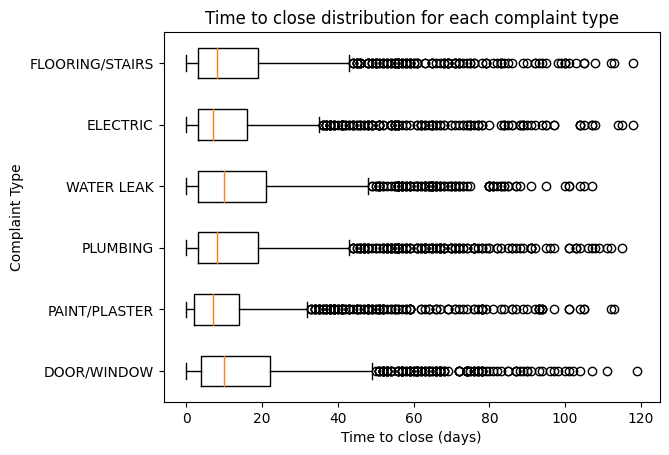

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, datediff, mean, stddev
from pyspark.sql.types import StructType, StructField, StringType, DateType

to_spark_df = balanced_df[["reportID", "created_date", "closed_date", "status", "complaint_type"]].copy()
to_spark_df = to_spark_df.assign(
    created_date=pd.to_datetime(to_spark_df["created_date"]),
    closed_date=pd.to_datetime(to_spark_df["closed_date"])
)

# Initialize the Spark session
spark = SparkSession.builder \
    .appName("Calculate Average Time to Close Requests") \
    .getOrCreate()

# Define the schema for the Spark DataFrame
schema = StructType([
    StructField("reportID", StringType(), False),
    StructField("created_date", DateType(), True),
    StructField("closed_date", DateType(), True),
    StructField("status", StringType(), True),
    StructField("complaint_type", StringType(), True),
])

# Convert the pandas DataFrame to a Spark DataFrame
spark_df = spark.createDataFrame(to_spark_df, schema=schema)

# Filter the closed maintenance requests
# Filter the closed maintenance requests
closed_requests = spark_df.filter((col("status") == "CLOSED") & (col("closed_date").isNotNull()))

# Calculate the time difference between the closed_date and created_date for each closed request
closed_requests = closed_requests.withColumn("time_to_close", datediff(col("closed_date"), col("created_date")))

# Calculate the global average time to close a maintenance request
global_avg_time_to_close = closed_requests.select(mean(col("time_to_close")).alias("global_avg_time_to_close")).collect()[0][0]
print(f"Global average time to close a maintenance request: {global_avg_time_to_close} days\n")

# Calculate the average time to close for each complaint type
avg_by_complaint_type = closed_requests.groupBy("complaint_type").agg(mean("time_to_close").alias("avg_time_to_close"), stddev("time_to_close").alias("stddev_time_to_close"))

avg_by_complaint_type.show()

# Calculate the distribution for each complaint type
complaint_types = closed_requests.select("complaint_type").distinct().collect()

data = []
labels = []

for complaint_type_row in complaint_types:
    complaint_type = complaint_type_row["complaint_type"]
    labels.append(complaint_type)

    # Filter closed requests for the current complaint type
    filtered_requests = closed_requests.filter(col("complaint_type") == complaint_type)

    # Collect the time to close values for the current complaint type
    time_to_close_values = filtered_requests.select("time_to_close").rdd.flatMap(lambda x: x).collect()
    data.append(time_to_close_values)

# Create a box plot for the distributions of time to close for each complaint type
fig, ax = plt.subplots()
ax.boxplot(data, labels=labels, vert=False)
ax.set_xlabel("Time to close (days)")
ax.set_ylabel("Complaint Type")
ax.set_title("Time to close distribution for each complaint type")
plt.show()


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, datediff, mean, count
from pyspark.sql.types import StructType, StructField, StringType, DateType

to_spark_df = balanced_df[["reportID", "created_date", "closed_date", "status", "complaint_type"]].copy()
to_spark_df = to_spark_df.assign(
    created_date=pd.to_datetime(to_spark_df["created_date"]),
    closed_date=pd.to_datetime(to_spark_df["closed_date"])
)

# Initialize the Spark session
spark = SparkSession.builder \
    .appName("Calculate Average Time to Close Requests") \
    .getOrCreate()

# Define the schema for the Spark DataFrame
schema = StructType([
    StructField("reportID", StringType(), False),
    StructField("created_date", DateType(), True),
    StructField("closed_date", DateType(), True),
    StructField("status", StringType(), True),
    StructField("complaint_type", StringType(), True),
])

# Convert the pandas DataFrame to a Spark DataFrame
spark_df = spark.createDataFrame(to_spark_df, schema=schema)

# Filter the closed maintenance requests
closed_requests = spark_df.filter(col("status") == "CLOSED")

# Calculate the time difference between the closed_date and created_date for each closed request
closed_requests = closed_requests.withColumn("time_to_close", datediff(col("closed_date"), col("created_date")))

# Calculate the global average time to close a maintenance request
global_avg_time_to_close = closed_requests.select(mean(col("time_to_close")).alias("global_avg_time_to_close")).collect()[0][0]

# Group by complaint_type and calculate the average time to close for each group
grouped_data = closed_requests.groupBy("complaint_type").agg(mean(col("time_to_close")).alias("avg_time_to_close"))

# Output the results
print(f"Global average time to close a maintenance request: {global_avg_time_to_close} days")
print("Average time to close for each complaint_type:")
grouped_data.show()

Global average time to close a maintenance request: 14.599426934097421 days
Average time to close for each complaint_type:
+---------------+------------------+
| complaint_type| avg_time_to_close|
+---------------+------------------+
|    DOOR/WINDOW|16.485974754558203|
|  PAINT/PLASTER|12.335044929396663|
|       PLUMBING|14.562841530054644|
|     WATER LEAK|16.628858024691358|
|       ELECTRIC|13.052993805918788|
|FLOORING/STAIRS| 14.93193717277487|
+---------------+------------------+



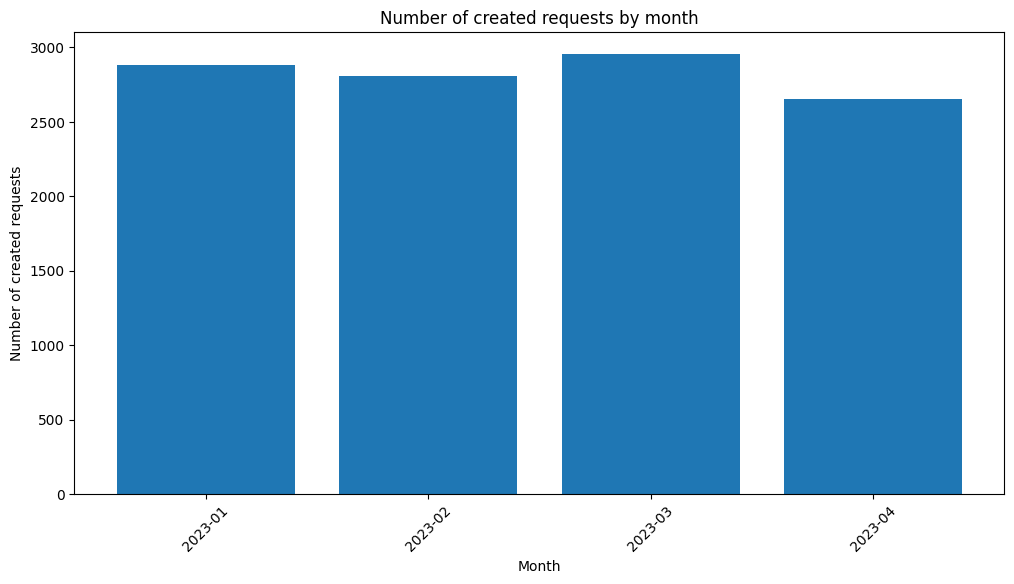

In [ ]:
import matplotlib.dates as mdates
from pyspark.sql.functions import col, count, month, year

# Convert the pandas DataFrame to a Spark DataFrame
spark_df = spark.createDataFrame(to_spark_df, schema=schema)

# Calculate the number of created requests by month, excluding May
created_requests_by_month = spark_df.filter(month(col("created_date")) != 5)\
    .groupBy(year(col("created_date")).alias("year"), month(col("created_date")).alias("month"))\
    .agg(count("reportID").alias("num_requests"))\
    .sort("year", "month")

# Convert the Spark DataFrame to a pandas DataFrame for plotting
created_requests_by_month_pd = created_requests_by_month.toPandas()

# Plot the number of created requests by month
plt.figure(figsize=(12, 6))
plt.bar(created_requests_by_month_pd.index, created_requests_by_month_pd["num_requests"])
plt.xticks(ticks=created_requests_by_month_pd.index, labels=["{}-{:02d}".format(y, m) for y, m in created_requests_by_month_pd[["year", "month"]].values], rotation=45)
plt.xlabel("Month")
plt.ylabel("Number of created requests")
plt.title("Number of created requests by month")
plt.show()

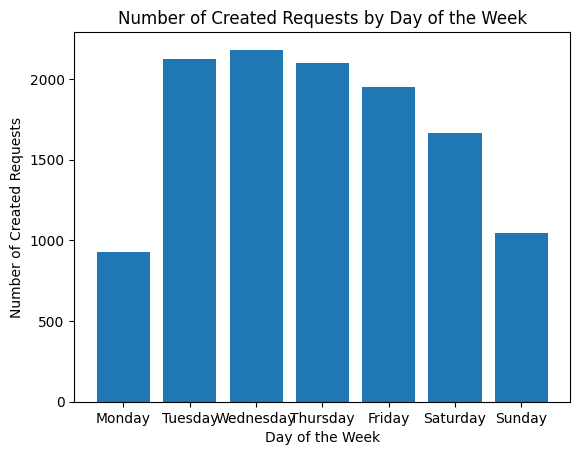

In [ ]:
from pyspark.sql.functions import dayofweek, count

# Calculate the number of created requests by day of the week
created_requests_by_dayofweek = spark_df.groupBy(dayofweek(col("created_date")).alias("day_of_week")) \
    .agg(count(col("reportID")).alias("num_created_requests")) \
    .sort("day_of_week") \
    .collect()

# Prepare the data for plotting
day_names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
x = np.arange(len(day_names))
y = [row['num_created_requests'] for row in created_requests_by_dayofweek]

# Create the bar chart
fig, ax = plt.subplots()
ax.bar(x, y)

# Customize the plot
ax.set_xticks(x)
ax.set_xticklabels(day_names)
ax.set_xlabel("Day of the Week")
ax.set_ylabel("Number of Created Requests")
ax.set_title("Number of Created Requests by Day of the Week")

# Show the plot
plt.show()


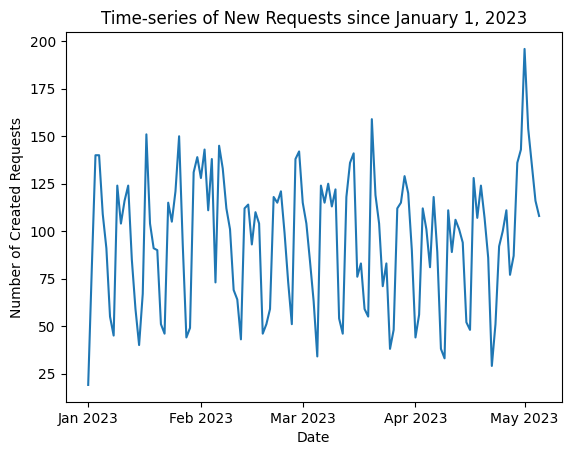

In [ ]:
import matplotlib.dates as mdates
from pyspark.sql.functions import count, to_date, lit

# Filter requests since January 1, 2023
filtered_requests = spark_df.filter(col("created_date") >= to_date(lit("2023-01-01")))

# Calculate the number of created requests per day
created_requests_by_date = filtered_requests.groupBy("created_date") \
    .agg(count(col("reportID")).alias("num_created_requests")) \
    .sort("created_date") \
    .collect()

# Prepare the data for plotting
x = [row['created_date'] for row in created_requests_by_date]
y = [row['num_created_requests'] for row in created_requests_by_date]

# Create the time-series plot
fig, ax = plt.subplots()
ax.plot(x, y)

# Customize the plot
ax.set_xlabel("Date")
ax.set_ylabel("Number of Created Requests")
ax.set_title("Time-series of New Requests since January 1, 2023")
ax.xaxis.set_major_locator(mdates.MonthLocator())  # Display x-axis ticks for each month
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))  # Format x
